### Tutorial for building an LSTM neural network for time-series prediction

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

### Importing the required libraries

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

# Scikit-Learn

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# GARCH model

#import pyflux as pf

# Keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Tensorflow

import tensorflow as tf

### Reading the csv file with the financial data

In [194]:
df = pd.read_csv(r'input/financial_data.csv')

print (df.head())
print (df.shape)

     20190610    20190611    20190612    20190613    20190614    20190617  \
0      134.38      135.32      135.56      135.13      135.44      135.39   
1      134.74      135.95      134.87      135.76      135.15      134.95   
2      135.35      136.46      135.94      136.27      135.88      136.03   
3      133.91      135.05      134.41      135.09      134.43      134.70   
4  2911327.00  3407345.00  2254741.00  2955419.00  2193367.00  2194129.00   

     20190618    20190619    20190620    20190621     ...        20200528  \
0      135.20      136.43      138.93      138.44     ...          126.87   
1      136.38      137.08      138.85      139.20     ...          124.53   
2      137.19      138.36      139.54      139.54     ...          126.97   
3      135.20      136.24      138.20      138.39     ...          124.22   
4  2914698.00  2382520.00  3071017.00  5288759.00     ...      3916377.00   

     20200529    20200601    20200602    20200603    20200604    20200605 

As we see here, we have 254 columns, corresponding to the 254 business days for which we have financial data and 10 columns, which are the 10 financial indicators we have.

### Transposing the dataframe 

As we are working with time series data, we should have the dates as one column and will thus use transpose() for this.

In [195]:
df = df.transpose()

print(df.head())
print(df.shape)

               0       1       2       3          4    5    6    7    8    9
20190610  134.38  134.74  135.35  133.91  2911327.0  0.0  0.0  0.0  0.0  0.0
20190611  135.32  135.95  136.46  135.05  3407345.0  0.0  0.0  0.0  0.0  0.0
20190612  135.56  134.87  135.94  134.41  2254741.0  0.0  0.0  0.0  0.0  0.0
20190613  135.13  135.76  136.27  135.09  2955419.0  0.0  0.0  0.0  0.0  0.0
20190614  135.44  135.15  135.88  134.43  2193367.0  0.0  0.0  0.0  0.0  0.0
(254, 10)


### Reset the index of the dataframe

In [196]:
df = df.reset_index()

print(df.head())

      index       0       1       2       3          4    5    6    7    8  \
0  20190610  134.38  134.74  135.35  133.91  2911327.0  0.0  0.0  0.0  0.0   
1  20190611  135.32  135.95  136.46  135.05  3407345.0  0.0  0.0  0.0  0.0   
2  20190612  135.56  134.87  135.94  134.41  2254741.0  0.0  0.0  0.0  0.0   
3  20190613  135.13  135.76  136.27  135.09  2955419.0  0.0  0.0  0.0  0.0   
4  20190614  135.44  135.15  135.88  134.43  2193367.0  0.0  0.0  0.0  0.0   

     9  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  


### Renaming the columns with the financial indicators name

In [197]:
df = df.rename(columns={
    
    df.columns[0]: 'Date',
    df.columns[1]:'Open',
    df.columns[2]: 'Close',
    df.columns[3]:'High',
    df.columns[4]:'Low',
    df.columns[5]: 'Volume',
    df.columns[6]: 'RSI14',
    df.columns[7]:'SMA14',
    df.columns[8]: 'EMA14',
    df.columns[9]:'MACD_sl',
    df.columns[10]:'MACD_h'

})

print (df.head())

       Date    Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
0  20190610  134.38  134.74  135.35  133.91  2911327.0    0.0    0.0    0.0   
1  20190611  135.32  135.95  136.46  135.05  3407345.0    0.0    0.0    0.0   
2  20190612  135.56  134.87  135.94  134.41  2254741.0    0.0    0.0    0.0   
3  20190613  135.13  135.76  136.27  135.09  2955419.0    0.0    0.0    0.0   
4  20190614  135.44  135.15  135.88  134.43  2193367.0    0.0    0.0    0.0   

   MACD_sl  MACD_h  
0      0.0     0.0  
1      0.0     0.0  
2      0.0     0.0  
3      0.0     0.0  
4      0.0     0.0  


### Converting the Date column into a Date

In [198]:
df['Date'] =  pd.to_datetime(df['Date'])

### Setting the Date column as the index

In [199]:
df.set_index('Date', inplace=True)

print(df.head())

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
2019-06-10  134.38  134.74  135.35  133.91  2911327.0    0.0    0.0    0.0   
2019-06-11  135.32  135.95  136.46  135.05  3407345.0    0.0    0.0    0.0   
2019-06-12  135.56  134.87  135.94  134.41  2254741.0    0.0    0.0    0.0   
2019-06-13  135.13  135.76  136.27  135.09  2955419.0    0.0    0.0    0.0   
2019-06-14  135.44  135.15  135.88  134.43  2193367.0    0.0    0.0    0.0   

            MACD_sl  MACD_h  
Date                         
2019-06-10      0.0     0.0  
2019-06-11      0.0     0.0  
2019-06-12      0.0     0.0  
2019-06-13      0.0     0.0  
2019-06-14      0.0     0.0  


## Engineering additional features

### Log Returns

In [200]:
df['Log_Returns'] = np.log(df.Close) - np.log(df.Close.shift(1))

print(df.head())

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
2019-06-10  134.38  134.74  135.35  133.91  2911327.0    0.0    0.0    0.0   
2019-06-11  135.32  135.95  136.46  135.05  3407345.0    0.0    0.0    0.0   
2019-06-12  135.56  134.87  135.94  134.41  2254741.0    0.0    0.0    0.0   
2019-06-13  135.13  135.76  136.27  135.09  2955419.0    0.0    0.0    0.0   
2019-06-14  135.44  135.15  135.88  134.43  2193367.0    0.0    0.0    0.0   

            MACD_sl  MACD_h  Log_Returns  
Date                                      
2019-06-10      0.0     0.0          NaN  
2019-06-11      0.0     0.0     0.008940  
2019-06-12      0.0     0.0    -0.007976  
2019-06-13      0.0     0.0     0.006577  
2019-06-14      0.0     0.0    -0.004503  


### Log Trading Range

In [201]:
df['Log_Trading_Range'] = np.log(df.High) - np.log(df.Low)

print(df.head())

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
2019-06-10  134.38  134.74  135.35  133.91  2911327.0    0.0    0.0    0.0   
2019-06-11  135.32  135.95  136.46  135.05  3407345.0    0.0    0.0    0.0   
2019-06-12  135.56  134.87  135.94  134.41  2254741.0    0.0    0.0    0.0   
2019-06-13  135.13  135.76  136.27  135.09  2955419.0    0.0    0.0    0.0   
2019-06-14  135.44  135.15  135.88  134.43  2193367.0    0.0    0.0    0.0   

            MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  
Date                                                         
2019-06-10      0.0     0.0          NaN           0.010696  
2019-06-11      0.0     0.0     0.008940           0.010386  
2019-06-12      0.0     0.0    -0.007976           0.011319  
2019-06-13      0.0     0.0     0.006577           0.008697  
2019-06-14      0.0     0.0    -0.004503           0.010729  


### Log Volume Change

In [202]:
df['Log_Volume_Change'] = np.log(df.Volume) - np.log(df.Volume.shift(1))

print(df.head())

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
2019-06-10  134.38  134.74  135.35  133.91  2911327.0    0.0    0.0    0.0   
2019-06-11  135.32  135.95  136.46  135.05  3407345.0    0.0    0.0    0.0   
2019-06-12  135.56  134.87  135.94  134.41  2254741.0    0.0    0.0    0.0   
2019-06-13  135.13  135.76  136.27  135.09  2955419.0    0.0    0.0    0.0   
2019-06-14  135.44  135.15  135.88  134.43  2193367.0    0.0    0.0    0.0   

            MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  Log_Volume_Change  
Date                                                                            
2019-06-10      0.0     0.0          NaN           0.010696                NaN  
2019-06-11      0.0     0.0     0.008940           0.010386           0.157324  
2019-06-12      0.0     0.0    -0.007976           0.011319          -0.412898  
2019-06-13      0.0     0.0     0.006577        

### Previous 10-day Volatility

In [203]:
df['Previous_10_Day_Volatility'] = df['Log_Returns'].rolling(window = 10).std()

print(df.tail())

              Open   Close    High     Low     Volume  RSI14   SMA14   EMA14  \
Date                                                                           
2020-06-04  127.78  128.89  128.95  127.02  3864785.0  76.16  123.09  124.33   
2020-06-05  133.88  132.06  134.23  131.75  5892960.0  79.04  124.17  125.36   
2020-06-08  132.27  135.75  135.88  132.27  5370469.0  78.30  125.18  126.74   
2020-06-09  133.52  131.87  133.60  131.02  5393644.0  70.92  126.01  127.43   
2020-06-10  132.15  129.87  132.23  129.80  4734835.0  64.85  126.62  127.75   

            MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  \
Date                                                          
2020-06-04     1.08    0.82    -0.001241           0.015080   
2020-06-05     1.34    1.01     0.024297           0.018649   
2020-06-08     1.66    1.30     0.027559           0.026927   
2020-06-09     1.95    1.15    -0.028998           0.019500   
2020-06-10     2.16    0.85    -0.015283           0.018548  

### Previous 30-day Volatility

In [204]:
df['Previous_30_Day_Volatility'] = df['Log_Returns'].rolling(window = 30).std()

print(df.head())

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
2019-06-10  134.38  134.74  135.35  133.91  2911327.0    0.0    0.0    0.0   
2019-06-11  135.32  135.95  136.46  135.05  3407345.0    0.0    0.0    0.0   
2019-06-12  135.56  134.87  135.94  134.41  2254741.0    0.0    0.0    0.0   
2019-06-13  135.13  135.76  136.27  135.09  2955419.0    0.0    0.0    0.0   
2019-06-14  135.44  135.15  135.88  134.43  2193367.0    0.0    0.0    0.0   

            MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  \
Date                                                          
2019-06-10      0.0     0.0          NaN           0.010696   
2019-06-11      0.0     0.0     0.008940           0.010386   
2019-06-12      0.0     0.0    -0.007976           0.011319   
2019-06-13      0.0     0.0     0.006577           0.008697   
2019-06-14      0.0     0.0    -0.004503           0.010729   

           

### Next 10-days volatility

In [205]:
df['Next_10_Days_Volatility'] = df['Log_Returns'].iloc[::-1].rolling(window = 10).std().iloc[::-1]

print(df.head())

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
2019-06-10  134.38  134.74  135.35  133.91  2911327.0    0.0    0.0    0.0   
2019-06-11  135.32  135.95  136.46  135.05  3407345.0    0.0    0.0    0.0   
2019-06-12  135.56  134.87  135.94  134.41  2254741.0    0.0    0.0    0.0   
2019-06-13  135.13  135.76  136.27  135.09  2955419.0    0.0    0.0    0.0   
2019-06-14  135.44  135.15  135.88  134.43  2193367.0    0.0    0.0    0.0   

            MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  \
Date                                                          
2019-06-10      0.0     0.0          NaN           0.010696   
2019-06-11      0.0     0.0     0.008940           0.010386   
2019-06-12      0.0     0.0    -0.007976           0.011319   
2019-06-13      0.0     0.0     0.006577           0.008697   
2019-06-14      0.0     0.0    -0.004503           0.010729   

           

In [206]:
print(df.tail())

              Open   Close    High     Low     Volume  RSI14   SMA14   EMA14  \
Date                                                                           
2020-06-04  127.78  128.89  128.95  127.02  3864785.0  76.16  123.09  124.33   
2020-06-05  133.88  132.06  134.23  131.75  5892960.0  79.04  124.17  125.36   
2020-06-08  132.27  135.75  135.88  132.27  5370469.0  78.30  125.18  126.74   
2020-06-09  133.52  131.87  133.60  131.02  5393644.0  70.92  126.01  127.43   
2020-06-10  132.15  129.87  132.23  129.80  4734835.0  64.85  126.62  127.75   

            MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  \
Date                                                          
2020-06-04     1.08    0.82    -0.001241           0.015080   
2020-06-05     1.34    1.01     0.024297           0.018649   
2020-06-08     1.66    1.30     0.027559           0.026927   
2020-06-09     1.95    1.15    -0.028998           0.019500   
2020-06-10     2.16    0.85    -0.015283           0.018548  

### Building a GARCH model using PyFlux

For the GARCH model, we train a new model for each separate stock. 

For each of those stocks, we fit a new GARCH model at each successive time step using all previous day, walking forward, as we would do if using the GARCH model on its own to trade. 

We train the GARCH models with parameters p=15 and q=15, with a horizon of 10 trading days (Figure 1).

In [207]:
#model = pf.GARCH(df, target = 'Log_Returns', p=1 ,q=1)

#x = model.fit()

#x.summary()

### Using the GARCH model to engineer a new feature

In [208]:
#print(model.predict(10))

# Look more into PyFlux

In [209]:
### Calculate the RMSE for GARCH Model

# Data Exploration

### Plotting out IBM's stock price since last year

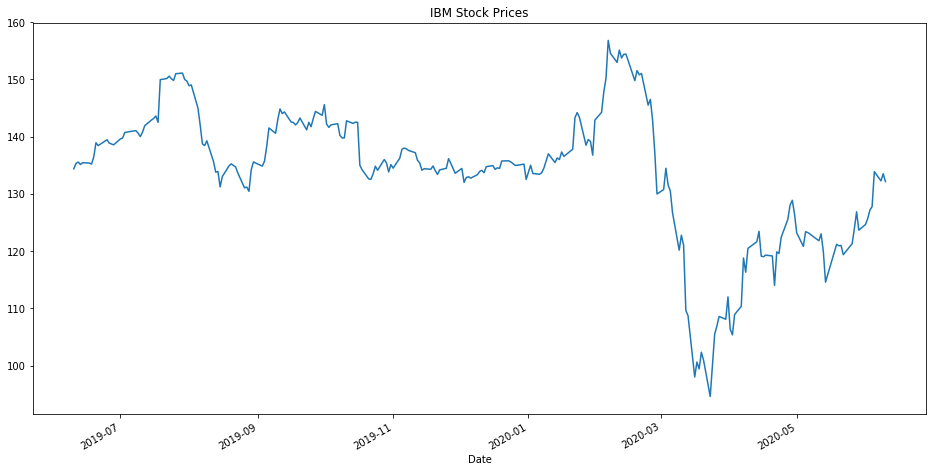

In [210]:
df['Open'].plot(label = 'IBM', figsize =(16,8), title = 'IBM Stock Prices')
plt.show()

### Plotting out 

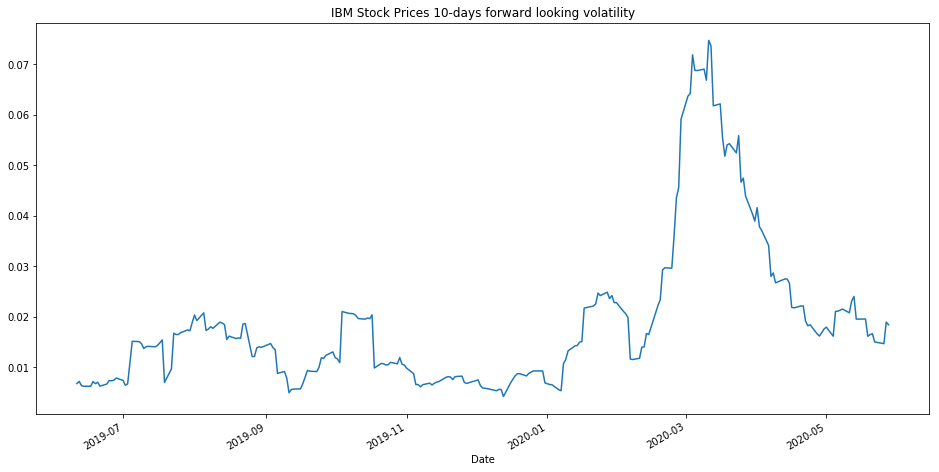

In [211]:
df['Next_10_Days_Volatility'].plot(label = 'IBM', figsize =(16,8), title = 'IBM Stock Prices 10-days forward looking volatility')
plt.show()

### Pearson Correlation Matrix

In [212]:
def build_pearson_correlation_matrix_of_dataframe(size_x,size_y,dataframe,correlation_target,correlation_minimum_criteria):

    # Using Pearson Correlation

    plt.figure(figsize=(size_x,size_y))
    cor = dataframe.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.savefig('Images/pearson_correlation_matrix.png', bbox_inches='tight')
    plt.show()

    # Correlation with output variable

    target = abs(cor[correlation_target])

    #Selecting and printing highly correlated features

    relevant_features = target[target>correlation_minimum_criteria]
    print(relevant_features)

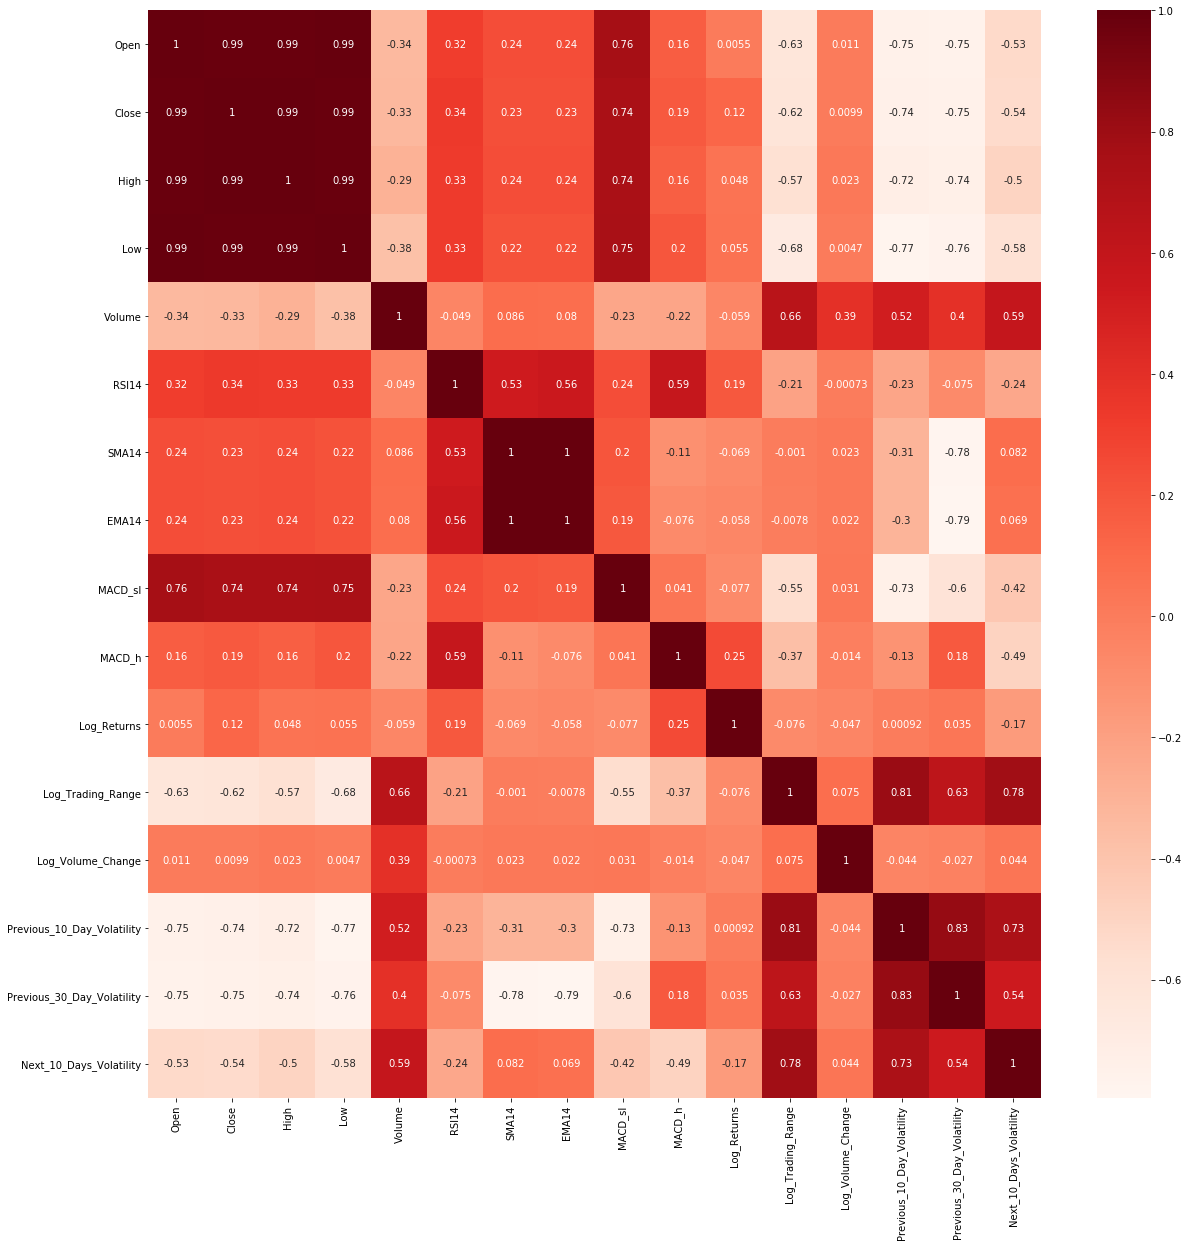

Open                          0.529545
Close                         0.538019
High                          0.498592
Low                           0.577579
Volume                        0.589667
RSI14                         0.239622
MACD_sl                       0.423028
MACD_h                        0.487282
Log_Trading_Range             0.783340
Previous_10_Day_Volatility    0.732002
Previous_30_Day_Volatility    0.539643
Next_10_Days_Volatility       1.000000
Name: Next_10_Days_Volatility, dtype: float64


In [213]:
build_pearson_correlation_matrix_of_dataframe(20,20,df,"Next_10_Days_Volatility",0.2)

# Data Preparation

### Normalizing the data

In [214]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

### Splitting into train and test sets

In [215]:
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size

train, test = df[0:train_size,:], df[train_size:len(df),:]

print("The train set contains " + str(len(train)) + " rows, and the test set contains " + str(len(test)) + " rows.")

The train set contains 177 rows, and the test set contains 77 rows.


### Defining a function to convert an array of values into a dataset matrix

In [216]:
def convert_an_array_of_values_into_a_dataset_matrix(dataset, look_back=1):
    
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-1):
        
        a = dataset[i:(i+look_back), 0]
        
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
        
    return np.array(dataX), np.array(dataY)

### Reshaping the dataset into X=t and Y=t+1

In [217]:
look_back = 1
trainX, trainY = convert_an_array_of_values_into_a_dataset_matrix(train, look_back)
testX, testY = convert_an_array_of_values_into_a_dataset_matrix(test, look_back)

### Reshaping input to be [samples, time steps, features]

In [218]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# LSTM Network

### Building the model

In [219]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Fitting the model

In [220]:
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
175/175 - 0s - loss: 0.1680
Epoch 2/100
175/175 - 0s - loss: 0.0119
Epoch 3/100
175/175 - 0s - loss: 0.0032
Epoch 4/100
175/175 - 0s - loss: 0.0031
Epoch 5/100
175/175 - 0s - loss: 0.0030
Epoch 6/100
175/175 - 0s - loss: 0.0029
Epoch 7/100
175/175 - 0s - loss: 0.0028
Epoch 8/100
175/175 - 0s - loss: 0.0027
Epoch 9/100
175/175 - 0s - loss: 0.0025
Epoch 10/100
175/175 - 0s - loss: 0.0025
Epoch 11/100
175/175 - 0s - loss: 0.0024
Epoch 12/100
175/175 - 0s - loss: 0.0022
Epoch 13/100
175/175 - 0s - loss: 0.0021
Epoch 14/100
175/175 - 0s - loss: 0.0019
Epoch 15/100
175/175 - 0s - loss: 0.0019
Epoch 16/100
175/175 - 0s - loss: 0.0017
Epoch 17/100
175/175 - 0s - loss: 0.0017
Epoch 18/100
175/175 - 0s - loss: 0.0015
Epoch 19/100
175/175 - 0s - loss: 0.0015
Epoch 20/100
175/175 - 0s - loss: 0.0014
Epoch 21/100
175/175 - 0s - loss: 0.0014
Epoch 22/100
175/175 - 0s - loss: 0.0013
Epoch 23/100
175/175 - 0s - loss: 0.0012
Epoch 24/100
175/175 - 0s - loss: 0.0011
Epoch 25/100
175/175 - 0s

### Making predictions

In [221]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

### Inverting the predictions

In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

### Calculating the RMSE

In [ ]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))